### Simple example 

- We assume three tasks. A real business task $T_{\$}$, a simplified human task $T_{h}$, and a purely computational task $T_{p}$.

- For simplicity, for now, we assume an artifact can be represented as a real number in $[-2,2]$. We will consider other extensions cases later. If an artifact blueprint is discrete we may wish to embed it into to a continous space, as suggested by Shahriari et al. "Taking the Human Out of the Loop".

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)
#


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import altair as alt
import numpy as np
import pandas as pd

def f_b(_x):
    return ((_x**4) - (2 * (_x ** 2)) + _x + 9).flatten()

def f_h(_x):
    return ((_x**(4)) - (6 * (_x ** 2)) + (.4 * _x) + 7).flatten()

def f_p(_x):
    return ((_x**(4)) - (4 * (_x ** 2)) + (.8 * _x) + 4).flatten()


MIN=-1
MAX=1

x = np.linspace(MIN, MAX, 200)
yb = np.asarray([f_b(i) for i in x])
yh =  np.asarray([f_h(i) for i in x])
yc =  np.asarray([f_p(i) for i in x])


data = [{"x": _x, "f(x)": _y[0], "kind": "business"} for _x, _y in zip(x, yb)]
data = data + [{"x": _x, "f(x)": _y[0], "kind": "human"} for _x, _y in zip(x, yh)]
data = data + [{"x": _x, "f(x)": _y[0], "kind": "computer"} for _x, _y in zip(x, yc)]

data = pd.DataFrame(data)

alt.Chart(data).mark_line().encode(
    x='x',
    y='f(x)',
    color='kind',
)

/opt/homebrew/anaconda3/envs/gp/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

### Notes

- The human and business task are correlated 
- The computer and human task are correlated
- The optimum for each of these tasks is different

In [4]:
from scipy.stats import pearsonr

correlation_bh = pearsonr(yb.flatten(), yh.flatten())[0]
correlation_ch = pearsonr(yc.flatten(), yh.flatten())[0]
correlation_bh, correlation_ch

(0.6303818868413656, 0.9528144373881672)

In [5]:
# Define the rbf kernel
import scipy
def rbf(xa, xb, sigma=1):
    '''returns a 1 X 1 matrix w/ RBF covariance'''
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return (sigma ** 2) * np.exp(sq_norm)


a = np.asarray([[1, 3]])
b = np.asarray([[3, 3]])
rbf(a, b)

array([[0.13533528]])

(-3.0, 3.0, 6.948115450060054, 75.0)

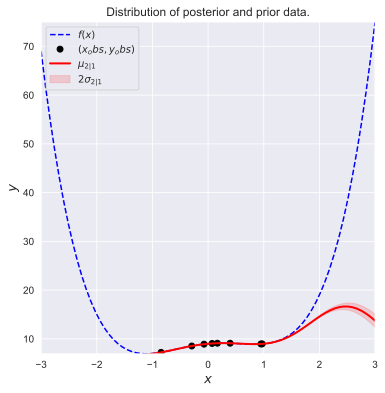

In [17]:
from code import GP

# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()
f = f_b

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-3, 3)

# Sample observations (X1, y1) on the function
observed_X = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
observed_y = f(observed_X)

# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(observed_X, observed_y, X2, rbf)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)


# Plot the postior distribution and some samples
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f(X2), 'b--', label='$f(x)$')
ax1.plot(observed_X, observed_y, 'ko', linewidth=2, label='$(x_obs, y_obs)$')

ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')

ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')

ax1.legend()
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], np.min(f(X2)), np.max(f(X2))])




In [14]:

from scipy.stats import pearsonr
from enum import Enum

class Task(Enum):
    COMPUTER = 0
    HUMAN = 1
    ORG = 2

class TaskKernel(object):
    '''
    Corresponds to K_t in Swersky et al. "Multi-Task Bayesian Optimization"
    
    Often, the similiarities will be set to the empirical correlations between tasks
    '''
    def __init__(self, similarities, Task):

        self.task = Task
        self.similarities = similarities

    def K_human(self, task1, task2):
        '''mostly for debugging/sanity checking'''
        dim1 = self.task[task1].value
        dim2 = self.task[task2].value
        return self.similarities[dim1, dim2]

    def K(self, task1: int, task2: int) -> float:
        '''in actual use people will call K here'''
        return self.similarities[task1, task2]

    
class MultiKernel(object):
    
    def __init__(self, task_kernel, input_kernel):
        self.task_kernel = task_kernel
        self.input_kernel = input_kernel
        
    # what are the types of x and xprime, assuming 1D for now
    def K(self, task1: int, task2: int, x, xprime): 
        '''
        This corresponds to taking the Kronecker product of the task Kernel K_t 
        and the regular input kernel K_x. To take the Kronecker product multiply
        K_x(x, xprime) by K_t(t, tprime) for each t in T.
        
        See Swersky et al. "Multi-Task Bayesian Optimization"
        '''
        return self.task_kernel.K(task1, task2) * self.input_kernel(x, xprime)

    
def compute_correlations():

    dim2array = {Task.COMPUTER.value: yc, 
                 Task.HUMAN.value: yh,
                 Task.ORG.value: yb}

    mx = np.zeros((3, 3))
    
    task_ids = [e.value for e in Task]
    
    for kind1 in task_ids:
        for kind2 in task_ids:
            a1 = dim2array[kind1]
            a2 = dim2array[kind2]
            mx[kind1, kind2] = pearsonr(a1.flatten(), a2.flatten())[0]
    return mx
            
correlation_bh = pearsonr(yb.flatten(), yh.flatten())[0]
correlation_ch = pearsonr(yc.flatten(), yh.flatten())[0]

mx = compute_correlations()
k = TaskKernel(mx, Task)

k.K_human(Task.COMPUTER.name, Task.HUMAN.name) == k.K(Task.COMPUTER.value, Task.HUMAN.value)

kt = TaskKernel(mx, Task)
kx = rbf
kmulti = MultiKernel(task_kernel=kt, input_kernel=kx)

In [18]:
a = np.asarray([[1, 3]])
b = np.asarray([[3, 3]])

kmulti.K(1, 1, a, b)

array([[0.13533528]])

In [19]:
from code import GP_multi

In [26]:
μa, Σa = GP_multi(observed_X, observed_y, 0, X2, 0, kmulti.K)

In [28]:
μa.shape, Σa.shape

((75,), (75, 75))

In [30]:
μ2.shape

(75,)

### Coregionalized GPs

- https://gpflow.readthedocs.io/en/v1.5.1-docs/notebooks/advanced/coregionalisation.html
- The use this for predicting the output of a simulation that takes a long time
- https://arxiv.org/pdf/2003.01115.pdf
- https://stats.stackexchange.com/questions/66709/confusion-related-to-predictive-distribution-of-gaussian-processes
- http://gaussianprocess.org/gpml/chapters/RW2.pdf
- http://gaussianprocess.org/gpml/chapters/RWA.pdf
- https://yugeten.github.io/posts/2019/09/GP/

In [ ]:
https://gpflow.readthedocs.io/en/v1.5.1-docs/notebooks/advanced/coregionalisation.html

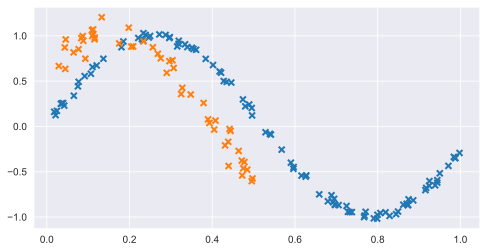

In [32]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1) # Observed locations for first output
X2 = np.random.rand(50, 1) * 0.5 # Observed locations for second output

Y1 = np.sin(6*X1) + np.random.randn(*X1.shape) * 0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.randn(*X2.shape) * 0.1

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2)

In [33]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2)))))

In [38]:
X_augmented

array([[0.49636625, 0.        ],
       [0.59684285, 0.        ],
       [0.33424389, 0.        ],
       [0.7709122 , 0.        ],
       [0.10659825, 0.        ],
       [0.07513778, 0.        ],
       [0.72818876, 0.        ],
       [0.49549132, 0.        ],
       [0.6884024 , 0.        ],
       [0.43482734, 0.        ],
       [0.24640203, 0.        ],
       [0.81910232, 0.        ],
       [0.79941588, 0.        ],
       [0.69469647, 0.        ],
       [0.27214514, 0.        ],
       [0.59023067, 0.        ],
       [0.3609739 , 0.        ],
       [0.09158207, 0.        ],
       [0.91731358, 0.        ],
       [0.13681863, 0.        ],
       [0.95023735, 0.        ],
       [0.44600577, 0.        ],
       [0.18513293, 0.        ],
       [0.54190095, 0.        ],
       [0.87294584, 0.        ],
       [0.73222489, 0.        ],
       [0.80656115, 0.        ],
       [0.65878337, 0.        ],
       [0.69227656, 0.        ],
       [0.84919565, 0.        ],
       [0.